#CNN

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

##gitting the images dataset
Cat&Dog

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2024-12-10 21:41:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.2MB/s    in 3.9s    

2024-12-10 21:42:02 (16.7 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

In [4]:
def create_dataset(path):
  # creating tow empty lists
  image_paths=[]
  image_labels=[]

  #looping over them
  for dir in os.listdir(path):
    for file in os.listdir(f'{path}/{dir}'):

      image_path = f'{path}/{dir}/{file}'
      image_label = 0 if dir == 'cats' else 1

      # appending the paths and labels into their lists
      image_paths.append(image_path)
      image_labels.append(image_label)

  # converting lists into numpy arrays
  image_paths = np.array(image_paths)
  image_labels = np.array(image_labels)

  return image_paths, image_labels

In [5]:
image_train, label_train = create_dataset('/content/cats_and_dogs_filtered/train')
image_test, label_test = create_dataset('/content/cats_and_dogs_filtered/validation')

In [6]:
image_train[22]


'/content/cats_and_dogs_filtered/train/dogs/dog.248.jpg'

In [7]:
image_train.shape, label_train.shape, image_test.shape, label_test.shape

((2000,), (2000,), (1000,), (1000,))

##Data Augmentation

In [30]:
def get_image_tensor_from_path(image_path, label):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (244, 244))

  return image, label

In [32]:
def augment_image(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=32.0/255.0)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

  image = tf.clip_by_value(image, 0.0, 0.1)
  return image, label

##Build the Dataset

In [33]:
def cd_dataset(x, y, batch_size=32, training=False):
  data = tf.data.Dataset.from_tensor_slices((x, y))

  data = data.map(get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if training:
    data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  data = data.shuffle(1000) # it shuffles the data (يشقلب الداتا)
  data = data.batch(batch_size) # it batches the data (تقسم الداتا)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data


In [34]:
train_dataset = cd_dataset(image_train, label_train, training=True)
test_dataset = cd_dataset(image_test, label_test)

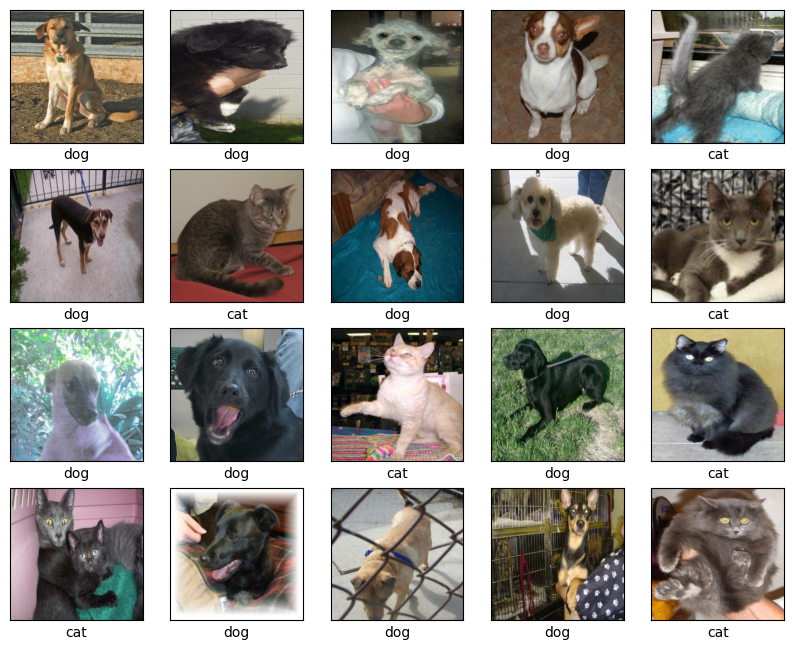

In [35]:
class_names = ['cat', 'dog']

for x,y in test_dataset.take(1):
  plt.figure(figsize=(10, 10))

  for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])

    plt.xlabel(class_names[y[i]])


##Building the model

In [36]:
model = keras.Sequential([
    keras.layers.Input(shape=(244, 244, 3)),
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(),

    keras.layers.Flatten(), # To convert 3D ==> 1D
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.1),

    keras.layers.Dense(units=1, activation=tf.nn.sigmoid),
])

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 244, 244, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 122, 122, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 30, 30, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 15, 15, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 15, 15, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,991,617 (30.49 MB)

 Trainable params: 7,991,617 (30.49 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile('adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.fit(train_dataset, epochs=10, validation_data = test_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 251ms/step - acc: 0.7035 - loss: 0.6311 - val_acc: 0.5000 - val_loss: 0.7286
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - acc: 0.3528 - loss: 0.7440 - val_acc: 0.5000 - val_loss: 0.7440
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - acc: 0.3726 - loss: 0.7228 - val_acc: 0.5000 - val_loss: 0.7401
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - acc: 0.4523 - loss: 0.7469 - val_acc: 0.5000 - val_loss: 0.7588
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - acc: 0.4432 - loss: 0.7057 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - acc: 0.6736 - loss: 0.6905 - val_acc: 0.5000 - val_loss: 1.2114
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - acc: 0.4484 - loss: 0.7418 - val_acc: 0.5000 - val_loss: 0.7204
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - acc: 0.3743 - loss: 0.7441 - val_acc: 0.5000 - val_loss: 0.8126
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/ste

In [19]:
train_history = pd.DataFrame(model.history.history)

<Axes: >

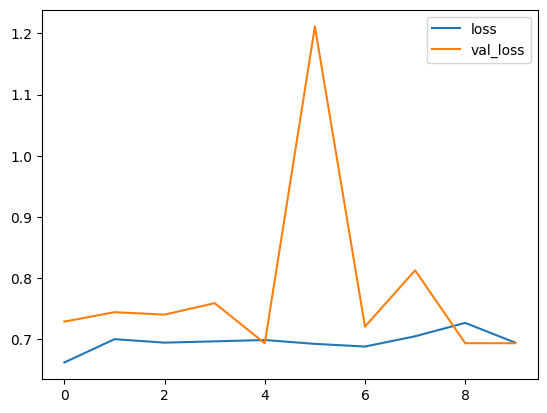

In [20]:
train_history[['loss','val_loss']].plot.line()

##Transfer learning
taking a model that is trained on a dataset and chage the last layer(top layer) and replace it with our data

In [21]:
model = tf.keras.applications.DenseNet121(
    include_top=False, #the defualt is true but we changed it to train the model on our data.
    input_shape=(244,244,3),
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 250, 250, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 61, 61, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 61, 61, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 61, 61, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [22]:
# to make the trainable parameters to zero.
model.trainable = False
model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 250, 250, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 61, 61, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 61, 61, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 61, 61, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [27]:
input = tf.keras.layers.Input(shape=(244,244,3)),
x = model(input, training=False)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)

out = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(x)

model = tf.keras.Model(inputs=[input], outputs=[out])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,883,073 (75.85 MB)

 Trainable params: 12,845,569 (49.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
model.compile('adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model.fit(train_dataset, epochs=8, validation_data = test_dataset)

Epoch 1/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - acc: 0.7001 - loss: 0.5861

In [ ]:
train_history = pd.DataFrame(model.history.history)
train_history

In [ ]:
train_history[['loss','val loss']].plot.line()